### Advanced Lane Finding
by: Lucas Hagel

Task List:
CHECK --> Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

CHECK --> Apply a distortion correction to raw images.

CHECK --> Use color transforms, gradients, etc., to create a thresholded binary image.

CHECK --> Apply a perspective transform to rectify binary image ("birds-eye view").

CHECK --> Detect lane pixels and fit to find the lane boundary.

CHECK --> Determine the curvature of the lane and vehicle position with respect to center.

CHECK --> Warp the detected lane boundaries back onto the original image.

CHECK --> Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from copy import deepcopy
%matplotlib inline

### Utility function to print side-by-sides

In [2]:
def display_two(a,b,ta,tb):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(a,cmap='gray')
    ax1.set_title(ta, fontsize=30)
    ax2.imshow(b,cmap='gray')
    ax2.set_title(tb, fontsize=30)
def display_three(R,G,B,t1,t2,t3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    f.tight_layout()
    ax1.imshow(R,cmap='gray')
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(G,cmap='gray')
    ax2.set_title(t2, fontsize=30)
    ax3.imshow(B,cmap='gray')
    ax3.set_title(t3, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Camera Calibration

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []
COLUMNS_TO_FIND = 6
objp = np.zeros((COLUMNS_TO_FIND*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:COLUMNS_TO_FIND].T.reshape(-1,2)

start = time.time()
for fname in images:
    
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (9,COLUMNS_TO_FIND),None)
    
    if ret == True:    
        imgpoints.append(corners)
        objpoints.append(objp)
        '''
        Test Lines
        img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
        print("corners 0 0 ", corners[0][0])
        print(len(corners),corners, ret)
        '''
fini = time.time()
print("It took {} seconds".format(str(fini-start)))

It took 2.6134519577026367 seconds


### Below returns distortion coef, camera matrix, rotation vec, translation vec 

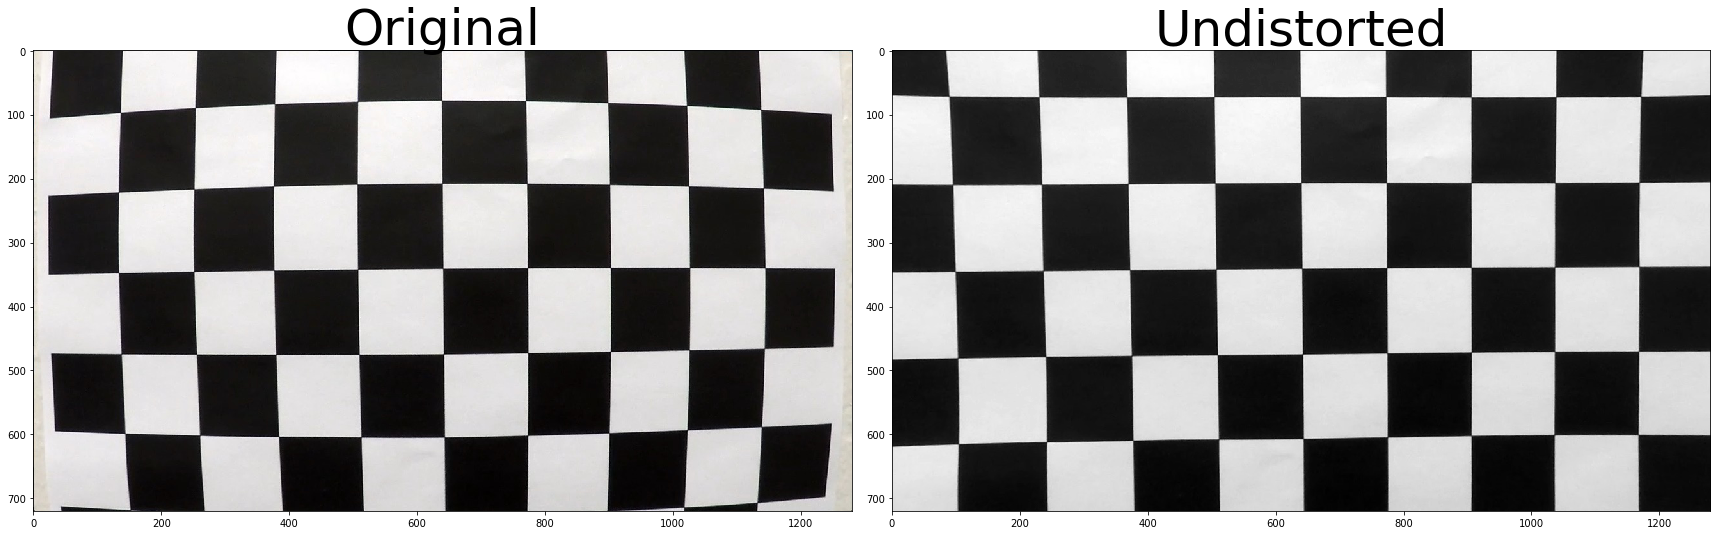

In [4]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)

img = mpimg.imread('./camera_cal//calibration1.jpg')
undist = np.copy(img)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(gray, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.tight_layout()
plt.savefig('./output-images/original-undistorted.png', dpi=300)

### Undistorts the image

In [5]:
def undistort(img):
    img2 = np.copy(img)
    return cv2.undistort(img2, mtx, dist, None, mtx)

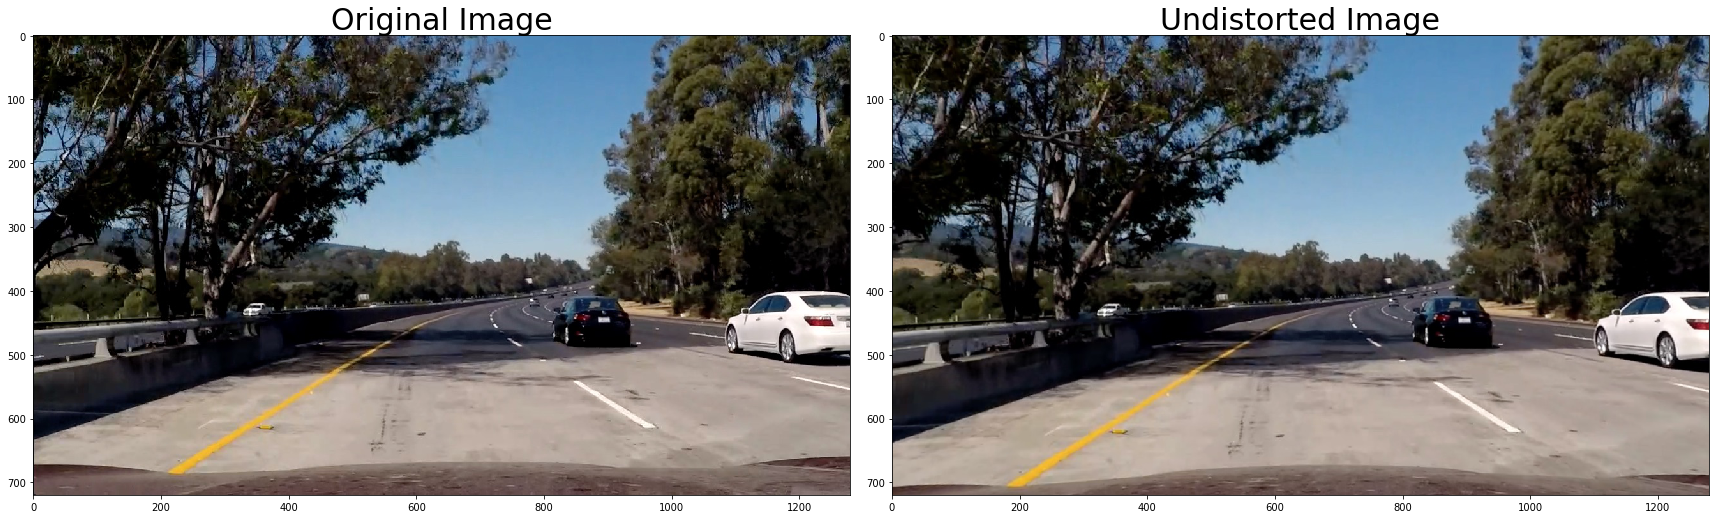

In [6]:
img = mpimg.imread('./test_images/test5.jpg')
undistorted = undistort(img)

display_two(img, undistorted,'Original Image','Undistorted Image')

## Unwarp / Rewarp Functions Which do Perspective Transform

In [7]:
def rewarp(img):
    
    img2 = np.copy(img)    
    
    img_size = (img.shape[1], img.shape[0])    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])        
    M_inverse = cv2.getPerspectiveTransform(dst,src)
    
    rewarped = cv2.warpPerspective(img2, M_inverse, img_size, flags=cv2.INTER_LINEAR)
    
    return rewarped

def unwarp(img):
    '''
    After many different iterations of finding the src and dst parameters, I consulted:
    https://github.com/JustinHeaton/Advanced-Lane-Finding/blob/master/Lane_Finding.ipynb    
    '''
    img2 = deepcopy(img)
    
    img_size = (img2.shape[1], img2.shape[0])
    '''
    corners = [[[585,450]],[[150,720]],[[1170,720]],[[740,450]]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[250,0], [250,700],[960,700], [960,0]])        
    '''
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src,dst)
    
    unwarped = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped


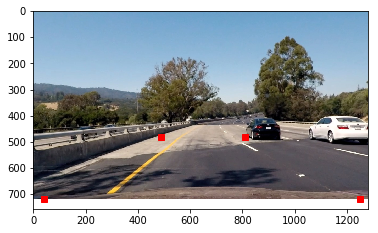

In [8]:
src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
image = undistort(mpimg.imread('./test_images/test4.jpg'))

plt.imshow(image)
for i in src:
    plt.plot(i[0],i[1],'rs')
#plt.savefig("./output-images/region-to-transform.png")

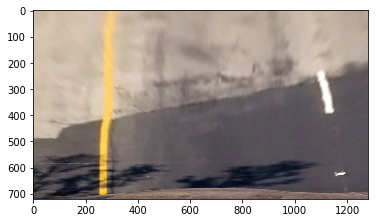

In [9]:
plt.imshow(unwarp(image))
#plt.savefig("./output-images/transformed-image.png")

## Helper Functions for Image Processing

In [10]:
def channelImageMaker(img_chann, tmin,tmax):
    '''
    Inputs:
        an image channel
        threshold minimum
        threshold maximum
    Output: a thresholded image, np.dstack gives it 3 channels as opposed to channelToThresh
    '''
    
    assert len(img_chann.shape) == 2, "Check the inputted image shape; insert a channel of an image"
    
    img_channel = np.copy(img_chann)
    binary = np.zeros_like(img_channel)
    binary[(img_chann >= tmin) & (img_chann <= tmax)] = 1

    spacer = np.zeros_like(img_channel)
    binary = np.dstack((spacer,binary, spacer) ) * 255
    
    return binary

def channelToThresh(channel,tmin, tmax):
    '''
    This function takes in a channel
    Outputs a thresholded binary of the channel using the inputted thresholds
    '''
    binary = np.zeros_like(channel)
    binary[ (channel > tmin) & (channel < tmax)] = 1
    return binary

def get_lane_lines(image_for_line_extraction):
    '''
    Input :    Undistorted image
    Output:    Thresholded and perspective transformed image 
    
    1 We convert the image to HLS,HSV,RGB 
    2 Get the thresholds that are helpful 
    3 OR them in the end
    '''
    
    rgb = np.copy(image_for_line_extraction)    
    img = np.copy(image_for_line_extraction)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)        
    H_hls = hls[:,:,0]
    H_hls = channelToThresh(H_hls,20,60)   
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V_hsv = hsv[:,:,2]
    V_hsv = channelToThresh(V_hsv,0,230 )
    V_hsv = cv2.bitwise_not(V_hsv)    
        
    B_rgb = rgb[:,:,2]
    B_rgb = channelToThresh(B_rgb, 190, 250)     
    
    R_rgb = rgb[:,:,0]
    R_rgb = channelToThresh(R_rgb, 0, 230)
    R_rgb = cv2.bitwise_not(R_rgb)    
    
    H_hls = cv2.blur(H_hls,(5,5))
    B_rgb = cv2.blur(B_rgb,(5,5))
    
    combined_binary = np.zeros_like(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    combined_binary[(V_hsv==1)| (H_hls == 1) | (B_rgb == 1) | (R_rgb==1)] = 1
    
    return unwarp(combined_binary)

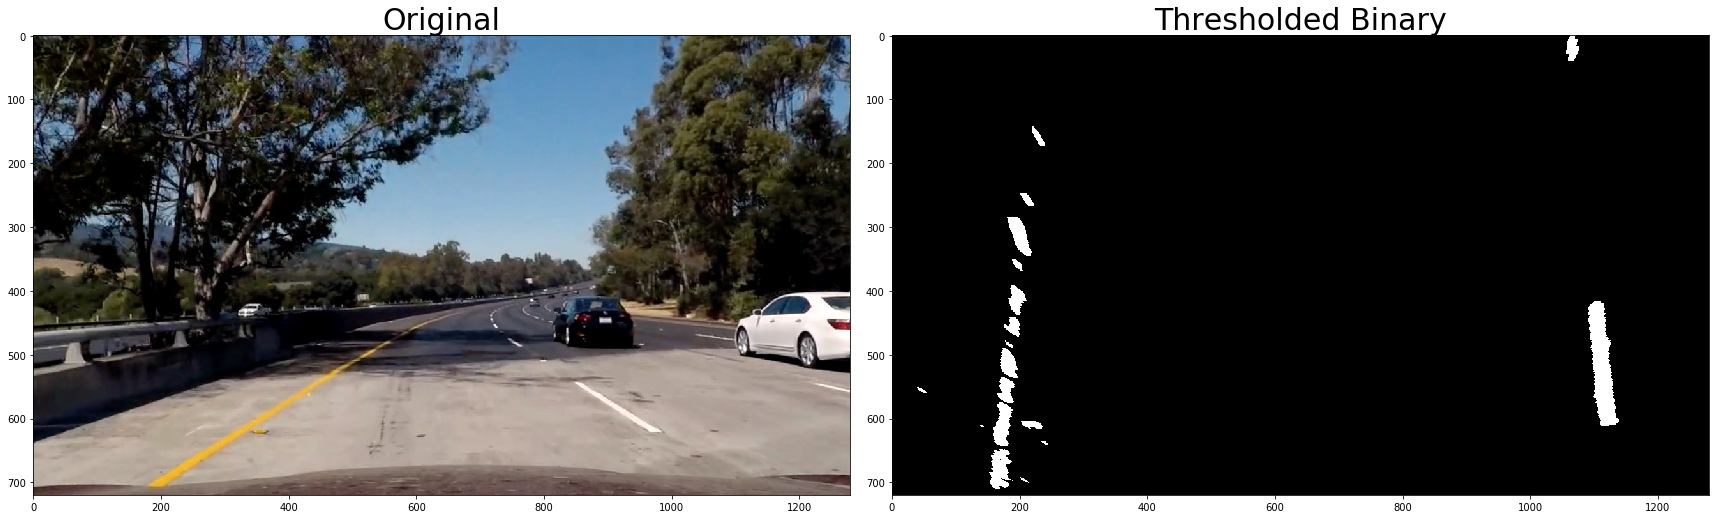

In [11]:
image = undistort(mpimg.imread('./test_images/test5.jpg'))
filtered= get_lane_lines(image)

display_two(image,filtered,"Original","Thresholded Binary")

# A Line Class to Handle Curve Fitting

In [12]:
from math import sqrt, isclose
from collections import deque
class LaneWatcher:
    def __init__(self):        
        self.isFirst = True
        self.leftprev = None
        self.rightprev = None
        self.prev_binary_warp = None      
        self.prev_curvemaker_LIST = None
        
        self.avgLeft        = deque(maxlen=20)
        self.avgRight       = deque(maxlen=20)
        self.avgLeft_curve  = 0
        self.avgRight_curve = 0
        
        self.weirdaverage = []
        self.nr = 0
    def updates_avg_curves(self,left_polyfit, right_polyfit):
        '''
        This function updates the instance record of up to the past 20 left/right polyfits
        It maintains the running average of the left and right polyfits
        
        '''
        self.avgLeft.append(left_polyfit)
        self.avgRight.append(right_polyfit)
        
        l1,l2,l3,r1,r2,r3 = 0,0,0,0,0,0
        for i in self.avgLeft:
            l1 += i[0]
            l2 += i[1]
            l3 += i[2]
        for i in self.avgRight:
            r1 += i[0]
            r2 += i[1]
            r3 += i[2]
        self.avgLeft_curve  = np.array([l1,l2,l3])
        self.avgRight_curve = np.array([r1,r2,r3])
        self.avgLeft_curve  /= len(self.avgLeft)
        self.avgRight_curve /= len(self.avgRight)
        
    def check_polyfit(self, left_polyfit, right_polyfit, binary_warped, curvemaker_list):        
        '''
        Checks if we should use the current polyfits:

                        1 it's getting fits as inputs 
                        2 it's within margins?
                        3 proximity to the center point
        '''
        #self.weirdaverage.append(right_polyfit)
        self.nr +=1
        if self.nr > 200:
            '''
            with open("Right_polyfits_for_averaging.log",'w') as fo:
                for data in self.weirdaverage:
                    el = np.array2string(data)
                    fo.write(el+'\n')
            '''
        #Is it the first iteration? --> If it's the first input we can't use the running average for smoothing
        if self.isFirst:
            self.isFirst = False                
            self.leftprev  = left_polyfit          
            self.rightprev = right_polyfit
            self.updates_avg_curves(left_polyfit, right_polyfit)
            return left_polyfit, right_polyfit, binary_warped, curvemaker_list
        
        ############ Did polyfit work? ####################
        elif left_polyfit.any() and right_polyfit.any() and len(left_polyfit)==3 and len(right_polyfit)==3:
            
            # here check if it's a deviant (dissimilar to the previously recorded curve)
            r, pr  = right_polyfit[0], self.avgRight_curve[0]           
            r2, pr2 = right_polyfit[1], self.avgRight_curve[1]
            r3,pr3 = right_polyfit[2], self.avgRight_curve[2]
            
            #if the fit is significantly different than previous polyfit, throw it out
            if abs(r - pr) > .01 or abs(r2 - pr2) > 20. or abs(r3 - pr3) > 3000.9612:
                '''
                with open("diagnostic-threshold.log",'w') as fo:
                    fo.write(str(self.nr))
                '''
                return .99*self.avgLeft_curve + .01*self.leftprev, .99*self.avgRight_curve+.01*self.rightprev, binary_warped, curvemaker_list#self.prev_binary_warp, self.prev_curvemaker_LIST#self.prev_binary_warp, self.prev_curvemaker_LIST
        
            
            self.updates_avg_curves(left_polyfit, right_polyfit)
            
            self.leftprev  = left_polyfit          
            self.rightprev = right_polyfit
            self.prev_binary_warp = binary_warped
            self.prev_curvemaker_LIST = curvemaker_list
            
            return .99*self.avgLeft_curve + .01*left_polyfit, .99*self.avgRight_curve+.01*right_polyfit, binary_warped, curvemaker_list
        #this return happens when the polyfit was unsuccessful
        return .99*self.avgLeft_curve + .01*self.leftprev, .99*self.avgRight_curve+.01*self.rightprev, binary_warped, curvemaker_list#self.prev_binary_warp, self.prev_curvemaker_LIST#self.prev_binary_warp, self.prev_curvemaker_LIST
        
    
    def warp_to_curve_naive(self, binary_warped):
        '''
        This functions takes in a unwarped thresholded image and outputs a 
        
        Returns: left_fit, 
                 right_fit, 
                 curvemaker_list (list of objects used to make the curve, 
                 points_for_polyfit (points used to generate the polyfit to be scaled to get center of radius)
        
        '''    
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)  
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 10        
        # Height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        margin = 100
        
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
            
            #Generates the window on the left and right side
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low, win_xleft_high  = leftx_current - margin, leftx_current + margin
            win_xright_low, win_xright_high = rightx_current - margin, rightx_current + margin
            
            #Checks the nonzero indices in the window 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Indices in the windows with the most points that we'll polyfit on
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #it one polyfit fails, screw it, we'll throw both away
        try:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        except TypeError:
            left_fit = np.array([])        
            right_fit = np.array([]) 
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        #List of items that will be used to generate the shaded region 
        curvemaker_list = [out_img, ploty,  nonzerox, nonzeroy, left_lane_inds, right_lane_inds]
        #points for a polyfit that will be scaled for calculating radii
        points_for_polyfit = [leftx,lefty, rightx,righty]
        
        if not left_fit.any() or not right_fit.any():
            return left_fit, right_fit, curvemaker_list, None    
        return left_fit, right_fit, curvemaker_list, points_for_polyfit

    def fitted_curve_to_mask_on_screen(self, img_start, left_fit, right_fit, curvemaker, font_points):
    
        out_img, ploty, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = curvemaker
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        window_img = np.zeros_like(out_img)
        
        left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        
        pts = np.hstack((left_line_window, right_line_window))

        cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)    
        newwarp = rewarp(window_img)    
        result = cv2.addWeighted(img_start, 1, newwarp, 0.5, 0)
        
        ############## To put the radius of curvature on the screen ##########
        if font_points:            
                
            leftx,lefty, rightx,righty = font_points

            ym_per_pix = 30/720  # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            y_eval = np.max(ploty)

            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            
            left_lane  = "%.2f" % left_curverad
            right_lane = "%.2f" % right_curverad
            
            # Get the offset from center by calculating car position (halfway across the image)
            # the center of the lane on the bottom part of the image
            # scale the difference between the center of the car and the car position
            img_h = out_img.shape[0]
            car_pos_horizontal = out_img.shape[1]/2
            l_ln_bottom = left_fit[0]*img_h**2  + left_fit[1]*img_h  + left_fit[2]
            r_ln_bottom = right_fit[0]*img_h**2 + right_fit[1]*img_h + right_fit[2]
            center_bottom = (r_ln_bottom - l_ln_bottom) / 2            
            offset_lane = (center_bottom-car_pos_horizontal)* xm_per_pix           
            
            left_or_right_title = "left"
            if offset_lane > 0:
                left_or_right_title = 'right'
            offset_lane = abs(offset_lane)    
            offset_lane = "%.2f" % offset_lane 
            
            radius_left  = "Left lane radius:  "  + str(left_lane) + 'm'
            radius_right = "Right lane radius: "  + str(right_lane) + 'm'
            center_place = "The car is: " + str(offset_lane) + 'm ' + left_or_right_title + " of center" 
            font = cv2.FONT_HERSHEY_SIMPLEX
            radius_curvature = (left_curverad + right_curverad) / 2 
            radius_curvature = "%.2f" % radius_curvature
            radius_actual = "Curve radius: "+ str(radius_curvature) + 'm'
            cv2.putText(result, radius_actual , ( 50, 50 ), font, 1.4, (240, 0, 0), 3, cv2.LINE_AA)
            
            cv2.putText(result, center_place, ( 50, 120), font, 1.4, (240, 0, 0), 3, cv2.LINE_AA)
        
        return result     

In [13]:
lane_watch = LaneWatcher()

def pipeline23(input_image):
    '''
    This pulls all the functions together
        Inputs: Image
        Outputs: An image with the lanes highlighted and the radius of curvature/distance from center on it
    
    How it works:
            1 input image is undistorted
            2 a thresholded binary is obtained via the get_lane_lines function
            3 the LaneWatcher instance creates a polyfit of the points
            4 the Lanewatcher instance smooths the polyfit, or uses the previous on based on the past polyfits
            5 fitted_curve_to_mask_on_screen highlights the lane region on the image
    '''
    img_start = undistort(np.copy(input_image))    
    binary_warped = get_lane_lines(img_start)    
    
    left_polyfit, right_polyfit, curvemaker_list, font_points = lane_watch.warp_to_curve_naive(binary_warped)
    left_polyfit, right_polyfit, binary_warped, curvemaker_list = lane_watch.check_polyfit(left_polyfit, right_polyfit, binary_warped, curvemaker_list)
    
    out_img = lane_watch.fitted_curve_to_mask_on_screen(img_start, left_polyfit, right_polyfit, curvemaker_list, font_points)
    
    return out_img


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline23)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [02:11<00:00,  9.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10min 24s, sys: 2min 31s, total: 12min 55s
Wall time: 2min 12s
